In [133]:
# Pre-requisite
#!python -m pip install --user -U nltk

# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
import datetime as dt
import nltk
sb.set() # set the default Seaborn style for graphics

# Import sklearn
from sklearn.preprocessing import MinMaxScaler

# Import Decision Tree Classifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, classification_report

In [134]:
stock_Train = pd.read_csv("../../Data/AAPLTrain.csv",parse_dates=['Date'],index_col=['Date'])
stock_Test = pd.read_csv("../../Data/AAPLTest.csv",parse_dates=['Date'],index_col=['Date'])
news_Train = pd.read_csv("../../Data/APPLNEWS_TRAIN.csv",parse_dates=['Date'],index_col=['Date'])
news_Test = pd.read_csv("../../Data/APPLNEWS_TEST.csv",encoding='cp1252',parse_dates=['Date'],index_col=['Date'])


In [135]:
stock_Train = stock_Train.loc[lambda x : x.index > dt.datetime(2012,12,31)]
df = pd.concat([stock_Train,stock_Test])
stock_Train["Rtx"] = df["Rtx"].loc[stock_Train.index[:-1]]
stock_Train = stock_Train.dropna()

# Data Preparation

In order to reduce and clean the data from irrelevant information, a filter process has been utilized. By filtering news articles that includes keywords like **"Apple,iPhone,iPad"**, we are able to attain a cleaner data with more relevance towards Apple.

In [136]:
news_Train = news_Train[news_Train['title'].str.contains('apple|iphone|ipad', case=False, na=False,regex=True)]
news_Train = news_Train.drop(columns=['published_date'])
news_Train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8375 entries, 2013-01-01 to 2021-09-08
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   8375 non-null   object
 1   link    8375 non-null   object
dtypes: object(2)
memory usage: 196.3+ KB


# News Data

News data is an unstructured dataset where it is hard to categorize data as it requires context for the complete understanding of data.

Hence, it is important to be able to convert the unstructured data into a structured data type with an assignment value.

## Metrics

The metrics used for categorizing the news is based on the sentiment of an article. Based on the sentiment of the article, the detection of the polarity and intensity expressed within the article, it is able to assign an appropriate value for the article.

## Sentiment Analysis

By analysing the sentiment of the article, it should be able to predict the correlation between the sentiment with the fluctuation of share values.

### Tools used

In order for the sentiment analysis of the article, the use of Natural Language Processing such as [Vader](https://github.com/cjhutto/vaderSentiment) has been used.

In [137]:
# nltk.download('vader_lexicon') #Pre-requisite for downloading

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [138]:
pd.options.mode.chained_assignment = None  # default='warn'
news_Train['scores'] = news_Train['title'].apply(lambda News: sid.polarity_scores(News))
news_Train['compound']  = news_Train['scores'].apply(lambda score_dict: score_dict['compound'])
news_Train['comp_score'] = news_Train['compound'].apply(lambda c: 'pos' if c > 0  else ('neg' if c < 0 else 'neu') )
news_Train = news_Train[news_Train['comp_score']!='neu']
news_Train.head()

,title,link,scores,compound,comp_score
Date,,,,,
2013-01-02,Court Rejects Apple’s False Advertising Claim ...,https://techcrunch.com/2013/01/02/court-reject...,"{'neg': 0.348, 'neu': 0.652, 'pos': 0.0, 'comp...",-0.4939,neg
2013-01-03,Apple said 'no thanks' to cellular Newton PDA ...,https://appleinsider.com/articles/13/01/03/app...,"{'neg': 0.182, 'neu': 0.579, 'pos': 0.24, 'com...",0.1779,pos
2013-01-06,Providing a Template to Challenge Apple - The ...,https://www.nytimes.com/2013/01/07/technology/...,"{'neg': 0.0, 'neu': 0.822, 'pos': 0.178, 'comp...",0.0772,pos
2013-01-09,Hard To Imagine Steve Jobs Running Apple This ...,https://www.forbes.com/sites/greatspeculations...,"{'neg': 0.149, 'neu': 0.851, 'pos': 0.0, 'comp...",-0.1027,neg
2013-01-10,"The Apple economy dominates CES 2013, but Sams...",https://www.theverge.com/2013/1/10/3862034/the...,"{'neg': 0.0, 'neu': 0.864, 'pos': 0.136, 'comp...",0.0258,pos
...,...,...,...,...,...
2021-09-01,Apple announces first states to adopt driver's...,https://www.apple.com/newsroom/2021/09/apple-a...,"{'neg': 0.0, 'neu': 0.779, 'pos': 0.221, 'comp...",0.1779,pos
2021-09-01,Today at Apple Creative Studios expands to Chi...,https://www.apple.com/newsroom/2021/09/today-a...,"{'neg': 0.0, 'neu': 0.583, 'pos': 0.417, 'comp...",0.5106,pos
2021-09-03,Apple Delays Rollout of Controversial Child Sa...,https://www.macrumors.com/2021/09/03/apple-del...,"{'neg': 0.231, 'neu': 0.769, 'pos': 0.0, 'comp...",-0.2023,neg


In [139]:
stock_Train = pd.merge(stock_Train,news_Train,how='inner',on="Date")
stock_Train = stock_Train.dropna(subset=['comp_score'])
stock_Train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2600 entries, 2013-01-02 to 2021-09-03
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        2600 non-null   float64
 1   High        2600 non-null   float64
 2   Low         2600 non-null   float64
 3   Close       2600 non-null   float64
 4   Adj Close   2600 non-null   float64
 5   Volume      2600 non-null   int64  
 6   Rtx         2600 non-null   float64
 7   title       2600 non-null   object 
 8   link        2600 non-null   object 
 9   scores      2600 non-null   object 
 10  compound    2600 non-null   float64
 11  comp_score  2600 non-null   object 
dtypes: float64(7), int64(1), object(4)
memory usage: 264.1+ KB


In [140]:
pd.options.mode.chained_assignment = None  # default='warn'
news_Test['scores'] = news_Test['title'].apply(lambda News: sid.polarity_scores(News))
news_Test['compound']  = news_Test['scores'].apply(lambda score_dict: score_dict['compound'])
news_Test['comp_score'] = news_Test['compound'].apply(lambda c: 'pos' if c > 0  else ('neg' if c < 0 else 'neu') )
news_Test = news_Test[news_Test['comp_score']!='neu']
news_Test.head()

,published_date,title,link,scores,compound,comp_score
Date,,,,,,
2021-09-08,2021-09-08T07:00:00+00:00,Apple App Store Changes Fail to Stem Push for ...,https://www.bloomberg.com/news/articles/2021-0...,"{'neg': 0.241, 'neu': 0.759, 'pos': 0.0, 'comp...",-0.5423,neg
2021-09-09,2021-09-09T07:00:00+00:00,Apple may have solved bending batteries for th...,https://appleinsider.com/articles/21/09/09/app...,"{'neg': 0.0, 'neu': 0.826, 'pos': 0.174, 'comp...",0.2732,pos
2021-09-10,2021-09-10T07:00:00+00:00,Several Apple Products Currently Experiencing ...,https://www.macrumors.com/2021/09/10/apple-pro...,"{'neg': 0.192, 'neu': 0.808, 'pos': 0.0, 'comp...",-0.2263,neg
2021-09-11,2021-09-11T07:00:00+00:00,Apple @ Work: Here’s why Apple Apple’s growth ...,https://9to5mac.com/2021/09/11/apples-continue...,"{'neg': 0.0, 'neu': 0.843, 'pos': 0.157, 'comp...",0.3818,pos
2021-09-12,2021-09-12T07:00:00+00:00,Apple still reliant on one core product as it ...,https://www.theguardian.com/technology/2021/se...,"{'neg': 0.0, 'neu': 0.897, 'pos': 0.103, 'comp...",0.1280,pos


In [141]:
stock_Test = pd.merge(stock_Test,news_Test,on="Date",how='inner')
stock_Test = stock_Test.dropna(subset=['comp_score'])

# Create a Decision Tree Classifier object
dectree2 = DecisionTreeClassifier(max_depth = 2)
dectree4 = DecisionTreeClassifier(max_depth = 4)

In [142]:
def Degree2():
    print("Degree2\n")
    dectree2.fit(x_train,y_train)

    f = plt.figure(figsize=(12,12))
    plot_tree(dectree2, filled=True, rounded=True, 
              feature_names=["Value"], 
              class_names=["Neg","Pos"])

    # Predict Legendary values corresponding to Total
    y_train_pred = dectree2.predict(x_train)
    y_test_pred = dectree2.predict(x_test)

    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Classification Accuracy \t:", dectree2.score(x_train, y_train))
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model \tTest Dataset")
    print("Classification Accuracy \t:", dectree2.score(x_test, y_test))
    print()
    
    print()
    cftr = confusion_matrix(y_train, y_train_pred)
    tp = cftr[1][1] / (cftr[1][1] + cftr[1][0])
    fp = cftr[0][1] / (cftr[0][1] + cftr[0][0])
    print("Train set")
    print("True Positive Rate \t: ", tp)
    print("False Positive Rate \t: ", fp)

    cftr = confusion_matrix(y_test, y_test_pred)
    tp = cftr[1][1] / (cftr[1][1] + cftr[1][0])
    fp = cftr[0][1] / (cftr[0][1] + cftr[0][0])
    print("Train set")
    print("True Positive Rate \t: ", tp)
    print("False Positive Rate \t: ", fp)

def Degree4():
    print("\nDegree4\n")
    dectree4.fit(x_train,y_train)

    f = plt.figure(figsize=(24,24))
    plot_tree(dectree4, filled=True, rounded=True, 
              feature_names=["Value"], 
              class_names=["Neg","Pos"])

    # Predict Legendary values corresponding to Total
    y_train_pred = dectree4.predict(x_train)
    y_test_pred = dectree4.predict(x_test)

    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Classification Accuracy \t:", dectree2.score(x_train, y_train))
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model \tTest Dataset")
    print("Classification Accuracy \t:", dectree2.score(x_test, y_test))
    print()
    
    
    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusion_matrix(y_train, y_train_pred),
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

    print()
    cftr = confusion_matrix(y_train, y_train_pred)
    tp = cftr[1][1] / (cftr[1][1] + cftr[1][0])
    fp = cftr[0][1] / (cftr[0][1] + cftr[0][0])
    print("Train set")
    print("True Positive Rate \t: ", tp)
    print("False Positive Rate \t: ", fp)

    cftr = confusion_matrix(y_test, y_test_pred)
    tp = cftr[1][1] / (cftr[1][1] + cftr[1][0])
    fp = cftr[0][1] / (cftr[0][1] + cftr[0][0])
    print("Train set")
    print("True Positive Rate \t: ", tp)
    print("False Positive Rate \t: ", fp)



# Regression Tree

In order to find the correlation between the sentiment of a new article with the stock price movement, daily returns has been chosen as the target for the regression tree.

By transforming the daily returns into a range of 0 - 2, we are able to fit the data into the model and continue classifying the new accordingly.

## Depth

To prevent the underfitting or overfitting of the model, we have utilized regression tree with different degrees.

In [143]:
pred = stock_Test
#to match the output we reduce the train size
stock_Train = stock_Train.iloc[-164:]

scaler_Lower = MinMaxScaler(feature_range=(0,1))
scaler_Upper = MinMaxScaler(feature_range=(1,2))
testing_Lower = scaler_Lower.fit_transform(np.array(stock_Train['Rtx'].loc[stock_Train.Rtx <= 0]).reshape(-1,1))
testing_Upper = scaler_Upper.fit_transform(np.array(stock_Train['Rtx'].loc[stock_Train.Rtx > 0]).reshape(-1,1))
testing = np.append(testing_Lower,testing_Upper,axis=0)
pred_Lower = scaler_Lower.fit_transform(np.array(stock_Test['Rtx'].loc[stock_Test.Rtx <= 0]).reshape(-1,1))
pred_Upper = scaler_Upper.fit_transform(np.array(stock_Test['Rtx'].loc[stock_Test.Rtx > 0]).reshape(-1,1))
pred_testing = np.append(pred_Lower,pred_Upper,axis=0)

Train Set : (164, 1) (164, 1)
Test Set  : (41, 1) (41, 1)

Degree2

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6036585365853658

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.5853658536585366


Train set
True Positive Rate 	:  1.0
False Positive Rate 	:  1.0
Train set
True Positive Rate 	:  1.0
False Positive Rate 	:  1.0

Degree4

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6036585365853658

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.5853658536585366


Train set
True Positive Rate 	:  0.9595959595959596
False Positive Rate 	:  0.8
Train set
True Positive Rate 	:  0.875
False Positive Rate 	:  0.5882352941176471


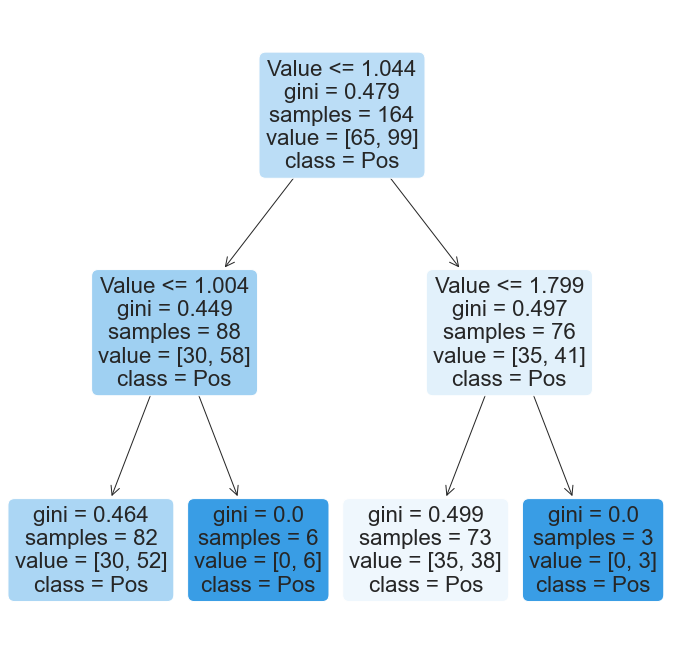

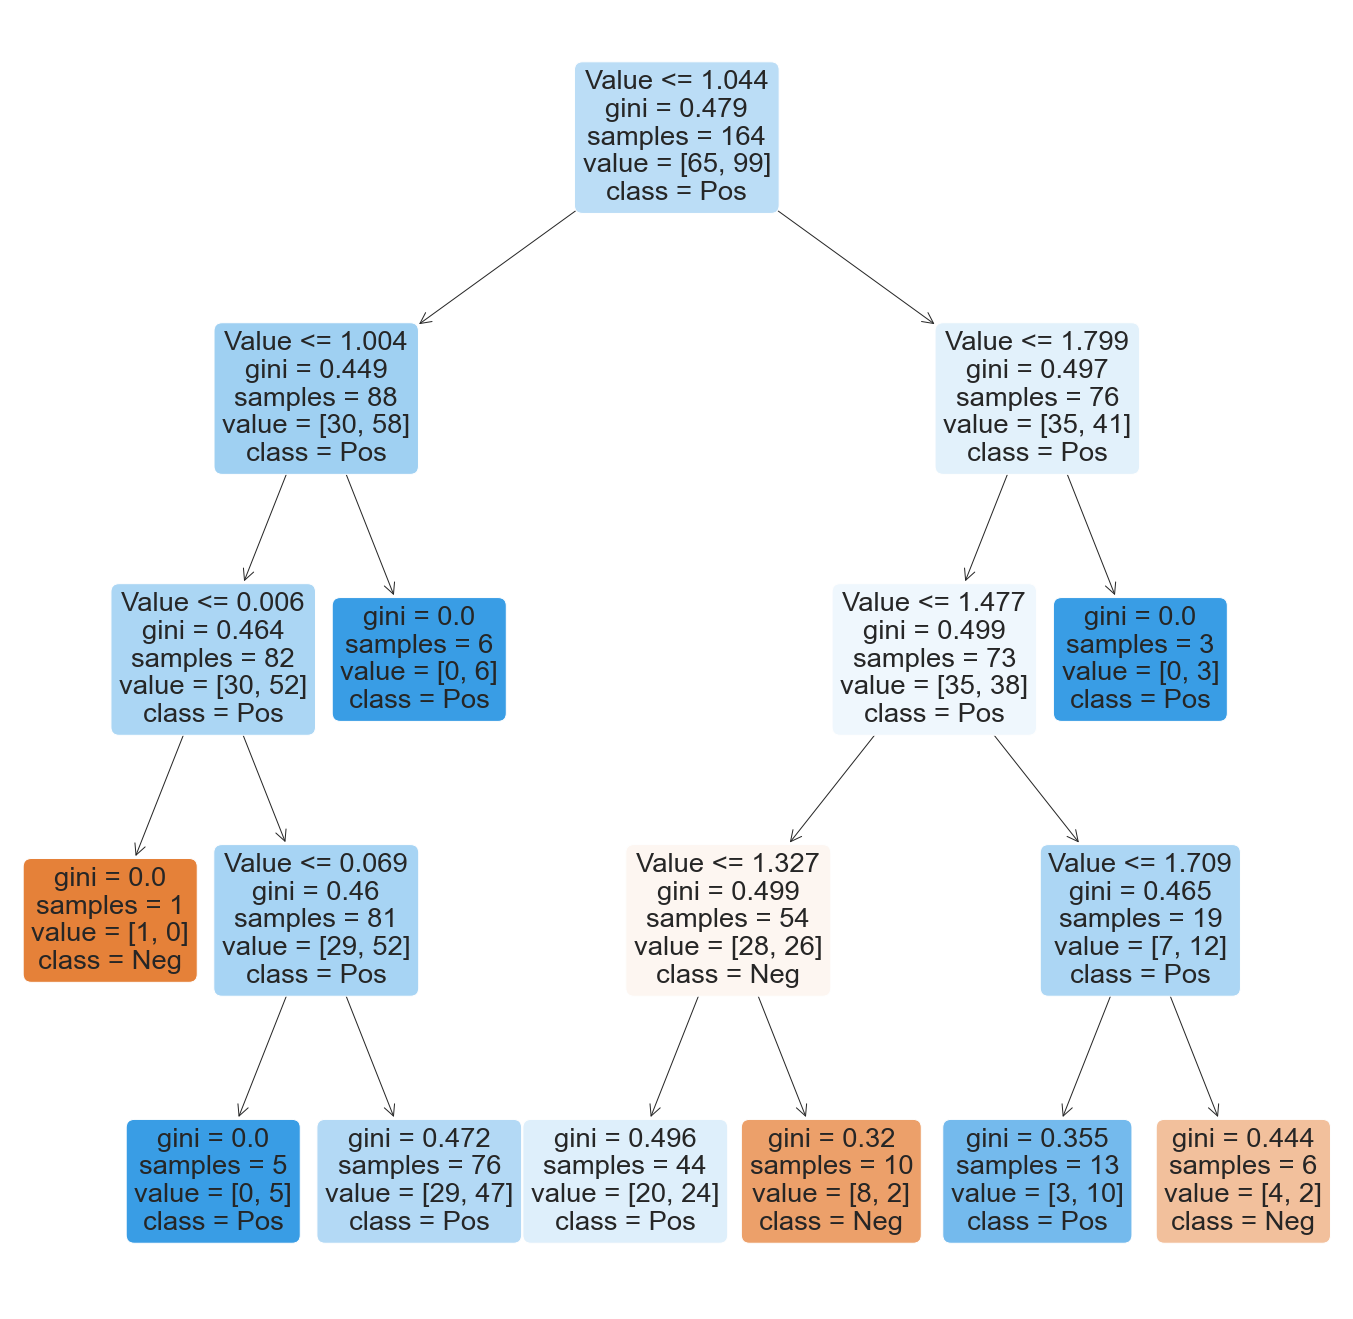

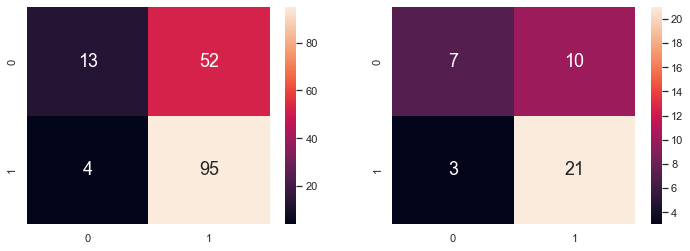

In [144]:
x_train = pd.DataFrame(testing)
x_test = pd.DataFrame(pred_testing)
y_train = pd.DataFrame(stock_Train['comp_score'])
y_test = pd.DataFrame(pred['comp_score'])

# Check the sample sizes
print("Train Set :", y_train.shape, x_train.shape)
print("Test Set  :", y_test.shape, x_test.shape)
print()
Degree2()
Degree4()

# Prediction

From the Regression Tree, the prediction for the correlation of positive news with increase in stock price are undefined. From the Regression Tree with a depth of 4, it shows that a positive new has correlations to both the increase and decrease of a price,thus making the correlation undefined.

# Further Reading on RegressionTree

To continue understanding the reason and application of LSTM, please continue on to the [documentation](../../Docs/algo_opt.md).

# Suggestion
However, there can be various factors which leads to an unclear definition of correlation such as:
 * Increase the Window for Target (From Daily returns --> Weekly Returns --> Monthly Returns)
 * Combination of Financial News with Social Media
 * Utilization of LSTM model with News as additional predictor